iteration: 0
depth: 1
Favorite child of root is:  I am a node named 1959887655984. with uct value:  0.18778967881731926
10 other uct values are: ,  [0.1877900434680454, 0.1877894615716198, 0.1877895553715877, 0.18778997079608412, 0.18778940395356916, 0.18778979465194498, 0.18778986533593234, 0.1877893572971203, 0.1877899525383596, 0.1877893755455134]
iteration: 1
depth: 2
Favorite child of root is:  I am a node named 1958867315280. with uct value:  0.18778933156446817
10 other uct values are: ,  [0.18778963893917924, 0.18778959938255815, 0.18778981631952962, 0.18778989362804652, 0.18778953672778345, 0.18778958720305938, 0.18778944987450816, 0.1877891040535652, 0.18778980491019268, 0.1877894015863122]
iteration: 2
depth: 2
Favorite child of root is:  I am a node named 1959886273664. with uct value:  0.1877896531190214
10 other uct values are: ,  [0.187789412572614, 0.1877891219059741, 0.18778919100069846, 0.18778953795514985, 0.18779006295870104, 0.18778960189721447, 0.18778966771492303

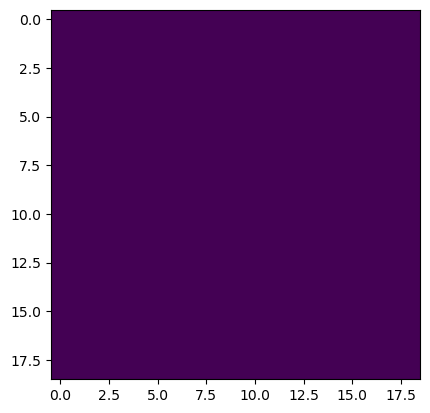

In [4]:
import copy
from baduk import *
from model import *
import matplotlib.pyplot as plt

# Time statistics collector
tsc = {
    'calculate_uct': 0,
    'node init': 0,
    'expand': 0,
    'policy': 0,
    'backpropagate': 0,
    'select_uct': 0,
}
def calculate_uct(node, c=20):
    """Calculate the UCT (Upper Confidence Bound for Trees) value from the perspective of the parent node."""

    p = node.policy
    explore = node.value / node.number
    exploit = p * c * np.sqrt(node.parent.number) / (1 + node.number)
    return explore + exploit + np.random.rand() * 1e-6


class Node:
    """Node in a Monte Carlo Tree Search (MCTS) tree."""

    def __init__(self, state, parent=None):
        global tsc
        tstart = time.perf_counter()
        self.board = state['board']
        self.ko_states = set() if parent is None else parent.ko_states
        self.parent = parent
        self.color = state['color']
        self.passed = state['passed']
        self.number = state['number']
        self.children = np.empty(0, dtype=Node)
        self.policy = state['policy']
        self.value = state['value']
        self.is_leaf = state['is_leaf']
        self.loc = state['loc']
        self.tracker = state['tracker']
        self.ko_states = state['ko_states']

        if self.tracker is None:
            tend = time.perf_counter()
            tsc['node init'] += tend - tstart
            self.ko_states = parent.ko_states

            tracky = BoardTracker()
            tracky.white = copy.deepcopy(parent.tracker.white)
            tracky.black = copy.deepcopy(parent.tracker.black)

            self.tracker = BoardTracker()
            self.tracker.white = tracky.white
            self.tracker.black = tracky.black

            self.board, self.tracker, self.ko_states = process(
                self.board, self.loc, self.color, self.tracker, self.ko_states
            )
            temp = self.tracker.white
            self.tracker.white = self.tracker.black
            self.tracker.black = temp

        self.legal_actions = (
            self.tracker.white.legal_moves
            if self.color == -1
            else self.tracker.black.legal_moves
        )

    def expand(self):
        """Expand the node by adding children for each legal move."""
        assert len(self.children) == 0
        global tsc
        tstart = time.perf_counter()
        legal_list = np.argwhere(self.legal_actions)
        if len(legal_list) == 0:
            raise ValueError('No legal moves!')
        count = 0
        children = np.empty(0, dtype=Node)
        x = self.board
        x_white = x == -1
        x_black = x == 1
        x_empty = x == 0
        x = np.stack((x_white, x_black, x_empty), axis=0, dtype=float)
        x = torch.tensor(x, dtype=torch.float32).clone().detach().unsqueeze(0)
        policy, value = policy_net(x)
        policy = policy.detach().numpy()
        value = value.detach().numpy().item()


        for loc in np.argwhere(self.legal_actions):
            count += 1
            new_board = self.board.copy()
            new_board, __ = action(new_board, loc, self.color, self.tracker)
            new_state = {
                'board': new_board,
                'loc': tuple(loc),
                'color': self.color * -1,
                'passed': False,
                'number': self.number + 1 + self.number+0.01 ** 2,
                'policy': policy[loc[0], loc[1]],
                'value': value,
                'is_leaf': True,
                'tracker': None,
                'ko_states': None,
            }
            new_state = Node(new_state, self)
            children = np.append(children, new_state)
        tend = time.perf_counter()
        tsc['expand'] += tend - tstart
        self.children = children
        self.is_leaf = False
        assert len(self.children) == len(legal_list)

    def __repr__(self):
        return f'I am a node named {id(self)}.'

    def backpropagate(self):
        """Propagate the results up the tree."""
        global tsc
        tstart = time.perf_counter()
        z = self.value
        node = self
        while node.parent is not root:
            node = node.parent
            node.number += 1
            node.value += z
        assert node.parent is root
        node.value -= 0.01
        tsc['backpropagate'] += time.perf_counter() - tstart

    def select_uct(self):
        """Select the child with the highest UCT value."""
        global tsc
        tstart = time.perf_counter()
        uct_values = []
        for child in self.children:
            uct = calculate_uct(child)
            uct_values.append(uct)
        uct_values = np.array(uct_values)
   #     print('uct values are: ', uct_values)
        where_max = np.argmax(uct_values)
    #    print('where max is: ', where_max)
        tend = time.perf_counter()
        tsc['select_uct'] += tend - tstart
        return self.children[where_max]


def dfs_child_count(root):
    """Perform a depth-first search to count all nodes."""
    visited = set()
    count = 0
    stack = [root]

    while stack:
        node = stack.pop()
        if node not in visited:
            visited.add(node)
            count += 1
            for child in node.children:
                if child not in visited:
                    stack.append(child)

    return count


def descend(node):
    """Descend the tree to a leaf node."""
    depth = 1
    while not node.is_leaf:
        node = node.select_uct()
        depth += 1
    print('depth:', depth)
    return node


def ascend(node):
    """Ascend the tree to the root."""
    while node.parent is not None:
        node = node.parent
    return node



def iteration(node):
    """Perform one iteration of the MCTS algorithm."""
    node = descend(node)
    node.expand()
    node = node.select_uct()
    node.backpropagate()
    node = ascend(node)


# Initialize the root node and start the iterations
x = np.zeros([19, 19], dtype=int)
initial_state = {
    'board': x,
    'loc': None,
    'color': 1,
    'passed': False,
    'number': 0,
    'policy': 1,
    'value': 0.0,
    'is_leaf': True,
    'tracker': BoardTracker(),
    'ko_states': set(),
}
root = Node(initial_state)
t0 = time.perf_counter()
policy_net = PolicyNet()

def n_iterations(n):
    for i in range(n):
        print('iteration:', i)
        iteration(root)
        print('Favorite child of root is: ', root.select_uct(), 'with uct value: ', calculate_uct(root.select_uct()))
        print('10 other uct values are: , ', [calculate_uct(i) for i in root.children[:10]])
    # Output the results
    print('Number of nodes:', dfs_child_count(root))
    print('Time information: ', tsc)
    print('Baduk time info (for comparison): ', time_consuming_functions)
    t2 = time.perf_counter()
    print('Time elapsed:', t2 - t0)
    for i in root.children:
        print('child is', i, 'number is: ', round(i.number), 'value is: ', i.value, 'uct is: ', calculate_uct(i))

def playout(node):
    """Complete a single self play game from the given node and return a tuple containing the winner and the final board state."""

if __name__ == '__main__':
    n_iterations(1000)
    plt.imshow(root.board)
    plt.show()

In [6]:
win_rates = []
for i in (root.children):
    win_rate = i.value/i.number if i.number > 0 else 0
    win_rates.append(win_rate)

highest_win = max(win_rates)
best_move = root.children[win_rates.index(highest_win)]
print('best move is: ', best_move.loc)



best move is:  (13, 15)


In [7]:
for i in root.children:
    print('child is', i, 'number is: ', round(i.number), 'value is: ', i.value, 'uct is: ', calculate_uct(i))

child is I am a node named 1959867069216. number is:  2 value is:  0.36978939712047576 uct is:  0.18488602143435998
child is I am a node named 1959884918944. number is:  2 value is:  0.358395522236824 uct is:  0.17918932832132012
child is I am a node named 1959866305904. number is:  2 value is:  0.364429389834404 uct is:  0.18220621965276557
child is I am a node named 1958845846048. number is:  4 value is:  0.7126452338695526 uct is:  0.17815696951963841
child is I am a node named 1959886269152. number is:  2 value is:  0.36079788744449615 uct is:  0.1803902062700372
child is I am a node named 1959886262672. number is:  2 value is:  0.3582132661342621 uct is:  0.17909838248768928
child is I am a node named 1959868150608. number is:  2 value is:  0.3610348308086395 uct is:  0.18050884118839708
child is I am a node named 1959886266464. number is:  2 value is:  0.3648938888311386 uct is:  0.18243881399965925
child is I am a node named 1959868148688. number is:  2 value is:  0.363978093266

In [ ]:
print('favorite root child is: ', root.select_uct())

In [ ]:
6.36744505912065/34

In [ ]:
best_move = root.select_wr()
print(best_move.loc)
print('best move wr is: ', calculate_win_rate(best_move))

In [ ]:

if __name__ == '__main__':
    n_iterations(1000)
    plt.imshow(root.board)
    plt.show()
        # Output the results
    print('Number of nodes:', dfs_child_count(root))
    print('Time information: ', tsc)
    print('Baduk time info (for comparison): ', time_consuming_functions)
    t2 = time.perf_counter()
    print('Time elapsed:', t2 - t0)

In [ ]:
for i in root.children:
    print(i.number)